# **Predicción de Ventas en Tiendas**

1.  **Carga de datos**: Importación de los conjuntos de datos de entrenamiento, prueba y metadatos (tiendas, petróleo, festivos).
2.  **Preprocesamiento**: Limpieza de datos, manejo de fechas y fusión de tablas.
3.  **Ingeniería de características**: Creación de variables temporales y gestión de eventos festivos.
4.  **Entrenamiento del modelo**: Uso de LightGBM para entrenar un modelo de regresión.
5.  **Predicción y envío**: Generación de predicciones para el conjunto de prueba y creación del archivo de envío.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("seaborn-v0_8")
sns.set_theme()

data_dir = "data"
if os.path.exists(data_dir):
    print("Archivos disponibles:", os.listdir(data_dir))
else:
    print(f"Directorio {data_dir} no encontrado. Directorio actual: {os.getcwd()}")

Archivos disponibles: ['submission.csv', 'oil.csv', 'transactions.csv', 'stores.csv', 'holidays_events.csv', 'test.csv', 'train.csv']


## **1. Importación de Librerías y Configuración**


In [2]:
train = pd.read_csv(f"{data_dir}/train.csv")
test = pd.read_csv(f"{data_dir}/test.csv")
stores = pd.read_csv(f"{data_dir}/stores.csv")
oil = pd.read_csv(f"{data_dir}/oil.csv")
holidays = pd.read_csv(f"{data_dir}/holidays_events.csv")
# transactions = pd.read_csv(f"{data_dir}/transactions.csv") # No se usa para predicción futura

## **2. Carga de Datos**

- `train.csv`: Datos históricos de ventas.
- `test.csv`: Datos para los cuales debemos predecir las ventas.
- `stores.csv`: Metadatos de las tiendas (ciudad, estado, tipo, cluster).
- `oil.csv`: Precios diarios del petróleo (indicador económico importante en Ecuador).
- `holidays_events.csv`: Información sobre días festivos y eventos.

_Nota: Aunque existe un archivo `transactions.csv`, no lo utilizaremos directamente para el entrenamiento ya que no disponemos de datos de transacciones futuras para el conjunto de prueba._


In [3]:
display(train.head())
display(train.info())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


None

## **3. Exploración Inicial**


In [4]:
print("Stores:")
display(stores.head())
print("\nOil:")
display(oil.head())
print("\nHolidays:")
display(holidays.head())

Stores:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



Oil:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20



Holidays:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
oil["date"] = pd.to_datetime(oil["date"])
holidays["date"] = pd.to_datetime(holidays["date"])

train = train.merge(stores, on="store_nbr", how="left")
test = test.merge(stores, on="store_nbr", how="left")

date_range = pd.date_range(
    start=min(oil["date"].min(), train["date"].min()),
    end=max(oil["date"].max(), test["date"].max()),
)
oil = oil.set_index("date").reindex(date_range).reset_index()
oil.rename(columns={"index": "date", "dcoilwtico": "oil_price"}, inplace=True)

oil["oil_price"] = oil["oil_price"].interpolate(method="linear").ffill().bfill()

train = train.merge(oil, on="date", how="left")
test = test.merge(oil, on="date", how="left")

print("Forma de Train después de merges:", train.shape)
print("Forma de Test después de merges:", test.shape)
display(train.head())

Forma de Train después de merges: (3000888, 11)
Forma de Test después de merges: (28512, 10)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


## **4. Preprocesamiento**

1.  **Conversión de fechas**: Aseguramos que todas las columnas de fecha tengan el formato `datetime` correcto.
2.  **Fusión con Stores**: Agregamos la información de la tienda a cada registro de venta.
3.  **Fusión con Oil**: Agregamos el precio del petróleo. Dado que el precio del petróleo puede tener valores faltantes (fines de semana, festivos), primero rellenamos el rango de fechas completo e interpolamos los valores faltantes linealmente.


In [6]:
holidays = holidays[holidays["transferred"] == False]

national_holidays = holidays[holidays["locale"] == "National"]
regional_holidays = holidays[holidays["locale"] == "Regional"]
local_holidays = holidays[holidays["locale"] == "Local"]

national_holidays = national_holidays[["date", "description"]].rename(
    columns={"description": "nat_holiday"}
)
train = train.merge(national_holidays, on="date", how="left")
test = test.merge(national_holidays, on="date", how="left")

regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"description": "reg_holiday", "locale_name": "state"}
)
train = train.merge(regional_holidays, on=["date", "state"], how="left")
test = test.merge(regional_holidays, on=["date", "state"], how="left")

local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"description": "loc_holiday", "locale_name": "city"}
)
train = train.merge(local_holidays, on=["date", "city"], how="left")
test = test.merge(local_holidays, on=["date", "city"], how="left")

train["holiday_type"] = (
    train["nat_holiday"]
    .fillna(train["reg_holiday"])
    .fillna(train["loc_holiday"])
    .fillna("No_Holiday")
)
test["holiday_type"] = (
    test["nat_holiday"]
    .fillna(test["reg_holiday"])
    .fillna(test["loc_holiday"])
    .fillna("No_Holiday")
)

train["is_holiday"] = (train["holiday_type"] != "No_Holiday").astype(int)
test["is_holiday"] = (test["holiday_type"] != "No_Holiday").astype(int)

train.drop(columns=["nat_holiday", "reg_holiday", "loc_holiday"], inplace=True)
test.drop(columns=["nat_holiday", "reg_holiday", "loc_holiday"], inplace=True)

print("Forma de Train después de merge de festivos:", train.shape)
display(train.head())

/tmp/ipykernel_7236/3666012553.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(test["reg_holiday"])


Forma de Train después de merge de festivos: (3008280, 13)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,oil_price,holiday_type,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1


## **5. Procesamiento de Festivos**

La gestión de festivos es compleja porque pueden ser Nacionales, Regionales o Locales. Además, algunos se transfieren a otra fecha. La lógica implementada es acorde a lo siguiente:

1.  Filtrar festivos "transferidos" (que ya no aplican en su fecha original).
2.  Separar festivos por alcance (Nacional, Regional, Local).
3.  Asignar el festivo correcto a cada fila de datos basándonos en la fecha y la ubicación (ciudad/estado) de la tienda.
4.  Prioridad: Si coinciden varios, asumimos una prioridad o simplemente marcamos si es festivo o no. Aquí simplificamos creando una columna `holiday_type` y una bandera binaria `is_holiday`.


In [7]:
print("Duplicados en train id:", train["id"].duplicated().sum())
print("Duplicados en test id:", test["id"].duplicated().sum())

train = train.drop_duplicates(subset=["id"])
test = test.drop_duplicates(subset=["id"])

print("Forma de Train después de eliminar duplicados:", train.shape)
print("Forma de Test después de eliminar duplicados:", test.shape)

Duplicados en train id: 7392
Duplicados en test id: 0
Forma de Train después de eliminar duplicados: (3000888, 13)
Forma de Test después de eliminar duplicados: (28512, 12)
Forma de Train después de eliminar duplicados: (3000888, 13)
Forma de Test después de eliminar duplicados: (28512, 12)


## **6. Limpieza de Duplicados**

El proceso de fusión (merge) con festivos puede haber generado duplicados si había múltiples eventos festivos en la misma fecha y lugar. Verificamos y eliminamos duplicados basándonos en el `id` único de la transacción.


In [8]:
def create_date_features(df):
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # Día de pago: 15 o último día del mes (común en Latinoamérica)
    df["is_payday"] = ((df["day"] == 15) | (df["date"].dt.is_month_end)).astype(int)

    return df


train = create_date_features(train)
test = create_date_features(test)

display(train.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,oil_price,holiday_type,is_holiday,year,month,day,dayofweek,is_weekend,is_payday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1,2013,1,1,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1,2013,1,1,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1,2013,1,1,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1,2013,1,1,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Primer dia del ano,1,2013,1,1,1,0,0


## **7. Feature Engineering**

Extraemos componentes útiles de la fecha como el año, mes, día, día de la semana, y si es fin de semana o día de pago (quincena/fin de mes), ya que estos factores influyen fuertemente en el comportamiento de compra.


In [9]:
from sklearn.preprocessing import LabelEncoder

# Transformación logarítmica del objetivo (Target)
train["sales"] = np.log1p(train["sales"])

# Columnas categóricas
cat_cols = ["family", "city", "state", "type", "holiday_type"]

# Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Ajustamos con train y test para cubrir todas las categorías posibles
    le.fit(pd.concat([train[col], test[col]]).astype(str))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    label_encoders[col] = le

display(train.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,oil_price,holiday_type,is_holiday,year,month,day,dayofweek,is_weekend,is_payday
0,0,2013-01-01,1,0,0.0,0,18,12,3,13,93.14,50,1,2013,1,1,1,0,0
1,1,2013-01-01,1,1,0.0,0,18,12,3,13,93.14,50,1,2013,1,1,1,0,0
2,2,2013-01-01,1,2,0.0,0,18,12,3,13,93.14,50,1,2013,1,1,1,0,0
3,3,2013-01-01,1,3,0.0,0,18,12,3,13,93.14,50,1,2013,1,1,1,0,0
4,4,2013-01-01,1,4,0.0,0,18,12,3,13,93.14,50,1,2013,1,1,1,0,0


## **8. Encoding**

Los modelos de Gradient Boosting (como LightGBM) requieren que las variables categóricas sean numéricas. Utilizamos `LabelEncoder` para transformar columnas como familia de productos, ciudad, estado y tipo de tienda.

Además, aplicamos una transformación logarítmica (`log1p`) a la variable objetivo `sales`. Esto ayuda a normalizar la distribución de las ventas y es consistente con la métrica de evaluación de la competencia (RMSLE - Root Mean Squared Logarithmic Error). Al predecir el logaritmo de las ventas y minimizar el RMSE, estamos optimizando efectivamente el RMSLE.


In [10]:
import lightgbm as lgb

# Definir características (features) y objetivo (target)
feature_cols = [col for col in train.columns if col not in ["id", "date", "sales"]]
print("Features utilizadas:", feature_cols)

# División temporal (Time-based split)
train_cutoff = "2017-07-31"
X_train = train[train["date"] < train_cutoff][feature_cols]
y_train = train[train["date"] < train_cutoff]["sales"]
X_val = train[train["date"] >= train_cutoff][feature_cols]
y_val = train[train["date"] >= train_cutoff]["sales"]

print("Forma de Training:", X_train.shape)
print("Forma de Validation:", X_val.shape)

# Crear datasets de LightGBM
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=cat_cols)

# Parámetros del modelo
params = {
    "objective": "regression",
    "metric": "rmse",  # RMSE sobre log(sales) equivale a RMSLE
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "seed": 42,
}

# Entrenar modelo
print("Entrenando modelo...")
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)],
)

Features utilizadas: ['store_nbr', 'family', 'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_price', 'holiday_type', 'is_holiday', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'is_payday']
Forma de Training: (2972376, 16)
Forma de Validation: (28512, 16)
Entrenando modelo...
Forma de Training: (2972376, 16)
Forma de Validation: (28512, 16)
Entrenando modelo...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.785625	valid_1's rmse: 0.699852
[100]	training's rmse: 0.785625	valid_1's rmse: 0.699852
[200]	training's rmse: 0.657792	valid_1's rmse: 0.6036
[200]	training's rmse: 0.657792	valid_1's rmse: 0.6036
[300]	training's rmse: 0.607326	valid_1's rmse: 0.549615
[300]	training's rmse: 0.607326	valid_1's rmse: 0.549615
[400]	training's rmse: 0.575466	valid_1's rmse: 0.527304
[400]	training's rmse: 0.575466	valid_1's rmse: 0.527304
[500]	training's rmse: 0.553266	valid_1's rmse: 0

## **9. Entrenamiento del Modelo**

Dado que es una serie temporal, no podemos usar una validación cruzada aleatoria (K-Fold) tradicional. Usamos una **división basada en el tiempo**:

- **Entrenamiento**: Datos anteriores al 31 de julio de 2017.
- **Validación**: Datos desde el 31 de julio de 2017 en adelante (últimas 2 semanas del set de entrenamiento).

Esto simula el escenario de predicción futura.


In [11]:
test_predictions = model.predict(test[feature_cols])
# Invertir transformación logarítmica
test_predictions = np.expm1(test_predictions)

submission = pd.DataFrame({"id": test["id"], "sales": test_predictions})

# Asegurar que no haya valores negativos
submission["sales"] = submission["sales"].clip(lower=0)

display(submission.head())

submission.to_csv(f"{data_dir}/submission.csv", index=False)
print("Archivo de envío guardado en submission.csv")

,id,sales
0,3000888,3.264928
1,3000889,0.076968
2,3000890,4.993884
3,3000891,2302.690283
4,3000892,0.150827


Archivo de envío guardado en submission.csv


## **10. Prediccion**

Realizamos predicciones sobre el conjunto de prueba.
**Importante**: Como entrenamos con `log1p(sales)`, debemos aplicar la inversa `expm1` a las predicciones para obtener las ventas reales.
También aseguramos que no haya ventas negativas (clipping a 0).


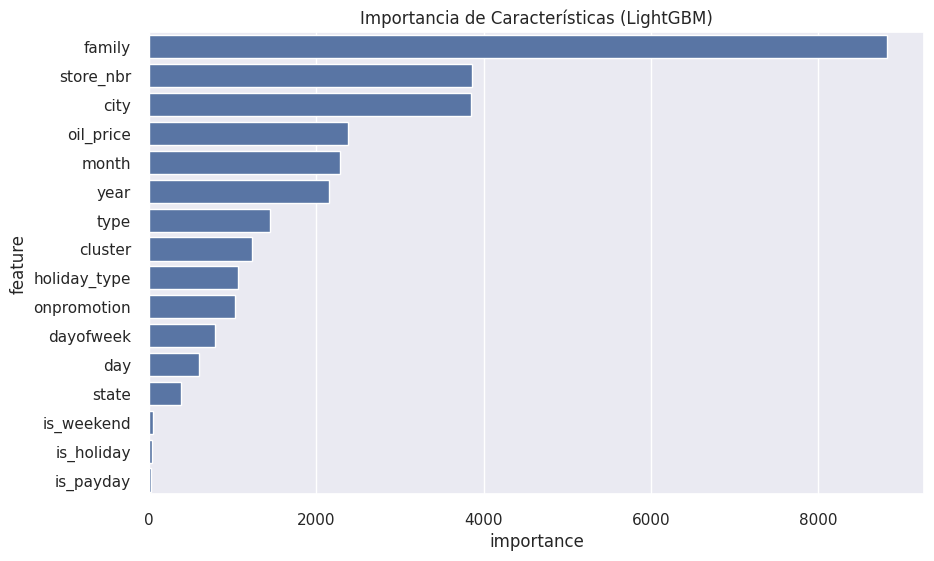

In [12]:
# Feature Importance
feature_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": model.feature_importance()}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Importancia de Características (LightGBM)")
plt.show()

![alt text](image.png)
